In [1]:
import os

# Set environment variables to disable multithreading as users will probably
# want to set the number of cores to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
###############################################################################
# Set TensorFlow print of log information
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from anomaly.constants import GALAXY_LINES
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData
from sdss.utils.managefiles import FileDirectory
from anomaly.utils import specobjid_to_idx
from anomaly.utils import set_intersection
from astroExplain.spectra.utils import get_anomaly_score_name
from astroExplain.spectra.notebook import explanation_name
from astroExplain.spectra.notebook import interpret
from astroExplain.spectra.notebook import explain_reconstruction_score

meta = MetaData()
%matplotlib inline

2022-09-23 10:27:07.319168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmp/.mount_SerenaFQXk2v/usr/lib:
2022-09-23 10:27:07.319190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# config
bin_id = "bin_04"
model_id = "0013"
architecture = "256_128_64/latent_12"
meta_data_directory = "/home/edgar/spectra/0_01_z_0_5_4_0_snr_inf"
model_directory = f"{meta_data_directory}/{bin_id}/models/{architecture}/{model_id}"
explanations_directory = f"{meta_data_directory}/{bin_id}/explanation/{architecture}"
scores_directory = f"{meta_data_directory}/bin_04/explanation/256_128_64/latent_12"

In [3]:
# load data
wave = np.load(f"{meta_data_directory}/wave.npy")
meta_data_df = pd.read_csv(f"{meta_data_directory}/0_01_z_0_5_4_0_snr_inf.csv.gz", index_col="specobjid")
model = AutoEncoder(reload=True, reload_from=model_directory)
spectra = np.load(f"{meta_data_directory}/spectra.npy", mmap_mode="r")
idx_id = np.load(f"{meta_data_directory}/{bin_id}/{bin_id}_index_specobjid.npy")

2022-09-23 10:27:11.825864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmp/.mount_SerenaFQXk2v/usr/lib:
2022-09-23 10:27:11.825881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-23 10:27:11.825896: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (edgar): /proc/driver/nvidia/version does not exist
2022-09-23 10:27:11.826251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# anomaly score
score_config = {
    "metric": "mse",
    "velocity": 250,
# if reconstruction
    "relative": True,
    "percentage": 97,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}


In [5]:
# spectrum
specobjid = 2664004586678806528
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]
# plt.plot(wave, spectrum)

### Original explanation

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


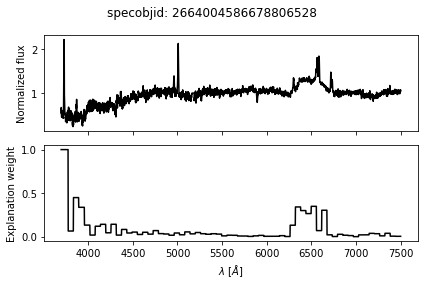

In [6]:
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": False,
    "kernel_size": 3,
    "sigma": 0
}

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/explanations"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_Str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_Str}.pdf"
# )

## Perturbation

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


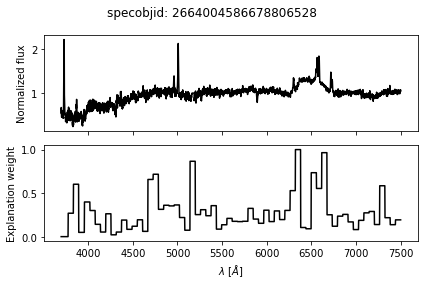

In [7]:
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "gaussians",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 0.9,
# gaussians
    "amplitude":0.1,
    "sigmas_in_segment": 10,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0.
}

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/perturbation"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
n_samples = lime_config["number_samples"]

# fig.savefig(
#     f"{save_to}/{explanation_str}_samples_{n_samples}.pdf"
# )

## Samples

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


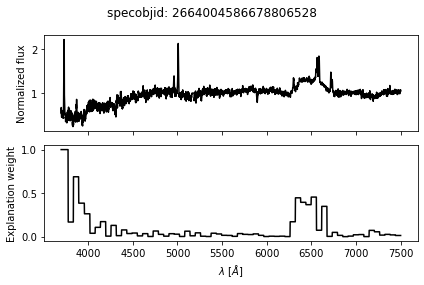

In [37]:
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 1000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/segmentation"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
n_samples = lime_config["number_samples"]

# fig.savefig(
#     f"{save_to}/{explanation_str}_samples_{n_samples}.pdf"
# )

## Segmentation

Set explainer and Get explanations
4
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=2664004586678806528&apid=


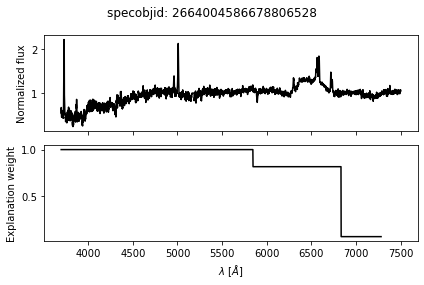

In [31]:
lime_config = {
    "segmentation": "kmeans",
    "number_segments": 10,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "scale",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": False,
    "kernel_size": 3,
    "sigma": 0
}
explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)
print(np.unique(explanation.segments).size)
fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/segmentation"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)
n_samples = lime_config["number_samples"]

# fig.savefig(
#     f"{save_to}/{explanation_str}_samples_{n_samples}.pdf"
# )

### Flat perturbation for string emission spectrum

Set explainer and Get explanations
Get heat map of explanation
http://skyserver.sdss.org/dr16/en/tools/explore/summary.aspx?sid=637325355518027776&apid=


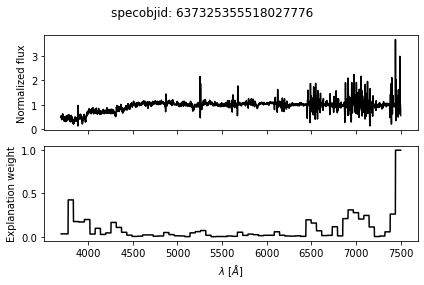

In [35]:
# config file
score_config = {
    "metric": "mse",
    "velocity": 0,
# if reconstruction
    "relative": 0,
    "percentage": 100,
    "epsilon": 0.001,
    "lines": list(GALAXY_LINES.keys())
}
lime_config = {
    "segmentation": "uniform",
    "number_segments": 64,
    "number_samples": 5000,
    "batch_size": 100,
    "progress_bar": False,
    "distance_metric": "cosine",
    "number_features": 10000
}
fudge_config = {
# same, same_shape, flat, with_mean, gaussians, scale
    "kind_of_fudge": "flat",
# scale
    "scale_factor": 0.9,
# flat
    "continuum": 1,
# gaussians
    "amplitude":1.,
    "sigmas_in_segment": 8,
# control-noise
    "same_noise": True,
    "kernel_size": 3,
    "sigma": 0
}
# Load data frame with anomalies
anomaly_from_score = "mse_noRel100"
anomalies_df = pd.read_csv(
    f"{explanations_directory}/{anomaly_from_score}/top_anomalies.csv.gz",
    index_col="specobjid"
)
# -22, 94
specobjid = anomalies_df.index[-94]
idx_spectrum = specobjid_to_idx(specobjid, idx_id)
spectrum = spectra[idx_spectrum]

explanation = explain_reconstruction_score(
    wave, spectrum,
    score_config, lime_config, fudge_config,
    model
)

fig, axs = interpret(wave, explanation=explanation, positive=0, negative=0, figsize=None)
print(meta.get_sky_server_url(specobjid))

fig.suptitle(f"specobjid: {specobjid}")
fig.tight_layout()

save_to = "/home/edgar/explain-me-why/sections/figures/perturbation"
FileDirectory.check_directory(save_to, exit_program=False)
explanation_str = explanation_name(lime_config, fudge_config)

# fig.savefig(
#     f"{save_to}/{specobjid}_{anomaly_from_score}_{explanation_str}.pdf"
# )